In [25]:
import torch
import pandas as pd
from dataset import XrayDataset
from multimodel import Multimodel
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from transformers import AutoModel, AutoProcessor, AutoConfig

In [20]:
MODEL_NAME = "StanfordAIMI/XraySigLIP__vit-l-16-siglip-384__webli"
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)
vision_full = AutoModel.from_pretrained(
    MODEL_NAME,
    config=config,
    trust_remote_code=True
).to(device, dtype)
vision_encoder = vision_full.vision_model
del vision_full

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [31]:
checkpoint_path= '/home/jupyter-nafisha/normal-abnormal-multitask/main/last_model.pth'

# img_dir = '/home/common/data_v3'
img_dir = '/home/jupyter-nafisha/Data/data_v3_CLAHE'
test_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/test_withoutBbox.csv'

# padchest
# img_dir = '/home/jupyter-nafisha/X-ray-covariates/padchest_normalized'
# test_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/padchest_withoutBbox.csv'

In [32]:
model = Multimodel(vision_encoder = vision_encoder).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

Multimodel(
  (vision_encoder): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(1024, 1024)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-23): 24 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024

In [33]:
test_dataset = XrayDataset(img_dir, test_csv, transform=None)
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4
)

In [34]:
# true_labels = test_dataset.df["label"].map({"Normal": 0, "Abnormal": 1}).tolist()
image_names = test_dataset.df["image_id"].tolist()

In [35]:
# predictions = []
# true_labels = []
# probabilities = []
# image_names = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


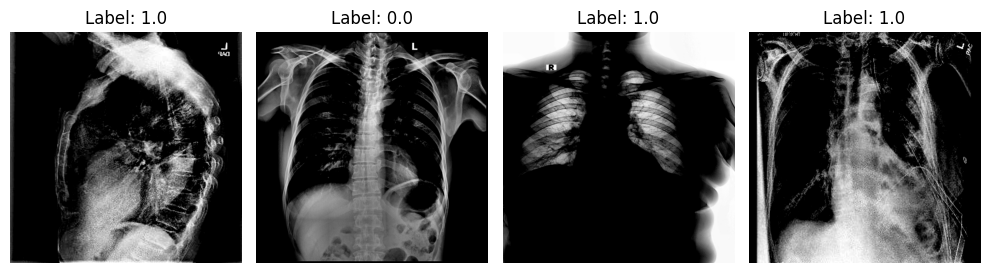

In [36]:
import matplotlib.pyplot as plt
import torch

for images, _, label, _, _l in test_loader:
    break  

# Plot 16 images in a 4x4 grid
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(4):
    img = images[i].permute(1, 2, 0)  # C,H,W → H,W,C
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label[i].item()}")

plt.tight_layout()
plt.show()

In [ ]:
# with torch.no_grad():
#     for images, _, labels, _, _ in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         preds = (torch.sigmoid(outputs) > 0.5).int()

#         predictions.extend(preds.cpu().tolist())
#         true_labels.extend(labels.int().tolist())

predictions = []
true_labels = []
# image_names = []
probabilities = []

with torch.no_grad():
    for images, _, labels, _, _ in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)                 # logits
        probs = torch.sigmoid(outputs).squeeze()  # probabilities

        preds = (probs > 0.5).int()

        probabilities.extend(probs.cpu().numpy())
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


In [ ]:
len(image_names), len(true_labels), len(predictions)

In [ ]:
df = pd.DataFrame({
    "image_name": image_names,
    "true_label": true_labels,
    "predicted_label": predictions
})

In [ ]:
# df[df['predicted_label']==1]
df

In [ ]:
# df.to_csv('original_test_dataset.csv', index= False)

In [ ]:
len(true_labels), len(probabilities)

In [ ]:
fpr, tpr, roc_thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
precision, recall, pr_thresholds = precision_recall_curve(true_labels, probabilities)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [ ]:
cm = confusion_matrix(true_labels, predictions)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

In [ ]:
print(f"Accuracy    : {accuracy_score(true_labels, predictions):.4f}")
print(f"Precision   : {precision_score(true_labels, predictions):.4f}")
print(f"Recall      : {recall_score(true_labels, predictions):.4f}")
print(f"Specificity : {specificity:.4f}")
print(f"F1 Score    : {f1_score(true_labels, predictions):.4f}")

In [ ]:
cm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix")
plt.show()

In [21]:
import pandas as pd
train_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/vinbig_test_withBBox.csv'
# train_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/val_withoutBbox_subset.csv'
data = pd.read_csv(train_csv)

In [49]:
import pandas as pd

train_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/vinbig_test_withBBox.csv'

df = pd.read_csv(train_csv)

# Split by label
normal_df = df[df['label'] == 'Normal'].drop_duplicates(subset=['image_id'])
abnormal_df = df[df['label'] == 'Abnormal'].drop_duplicates(subset=['image_id'])

# Sample 50 each (set random_state for reproducibility)
normal_sample = normal_df.sample(n=50, random_state=42)
abnormal_sample = abnormal_df.sample(n=50, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([normal_sample, abnormal_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: save
balanced_df.to_csv('/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/vinbig_balanced_100.csv', index=False)

# print(balanced_df['label'].value_counts())
# print('Unique image_ids:', balanced_df['image_id'].nunique())


In [48]:
import numpy as np
len(np.unique(balanced_df['image_id']))

100

In [28]:
vinbig

,image_id,sex,orientation,x_min,y_min,x_max,y_max,class_name,label
0,vinbig/50a418190bc3fb1ef1633bf9678929b3.jpg,M,PA,NaN,NaN,NaN,NaN,No finding,Normal
1,vinbig/051132a778e61a86eb147c7c6f564dfe.jpg,F,PA,1264.0,743.0,1611.0,1019.0,Aortic enlargement,Abnormal
2,vinbig/063319de25ce7edb9b1c6b8881290140.jpg,F,PA,NaN,NaN,NaN,NaN,No finding,Normal
3,vinbig/1c32170b4af4ce1a3030eb8167753b06.jpg,M,PA,627.0,357.0,947.0,433.0,Pleural thickening,Abnormal
4,vinbig/47ed17dcb2cbeec15182ed335a8b5a9e.jpg,F,PA,557.0,2352.0,675.0,2484.0,Nodule/Mass,Abnormal
...,...,...,...,...,...,...,...,...,...
20391,vinbig/8ef3fb1b703ffcb77d3709d45adf8695.jpg,M,PA,1359.0,772.0,1628.0,1051.0,Aortic enlargement,Abnormal
20392,vinbig/d59d5dcc1601a29509f91dab5f8550bc.jpg,F,PA,1678.0,1097.0,1824.0,1434.0,Lung Opacity,Abnormal
20393,vinbig/2860567dbd5d3f2597072e0b0e45ccd6.jpg,M,PA,253.0,1626.0,771.0,1966.0,Lung Opacity,Abnormal
20394,vinbig/b53d1dd80e99ca6bcef9d592f65d3321.jpg,F,PA,240.0,1550.0,562.0,2001.0,Pleural effusion,Abnormal


In [29]:
vinbig[vinbig['label']== 'Abnormal']

,image_id,sex,orientation,x_min,y_min,x_max,y_max,class_name,label
1,vinbig/051132a778e61a86eb147c7c6f564dfe.jpg,F,PA,1264.0,743.0,1611.0,1019.0,Aortic enlargement,Abnormal
3,vinbig/1c32170b4af4ce1a3030eb8167753b06.jpg,M,PA,627.0,357.0,947.0,433.0,Pleural thickening,Abnormal
4,vinbig/47ed17dcb2cbeec15182ed335a8b5a9e.jpg,F,PA,557.0,2352.0,675.0,2484.0,Nodule/Mass,Abnormal
5,vinbig/d3637a1935a905b3c326af31389cb846.jpg,M,PA,1329.0,743.0,1521.0,958.0,Aortic enlargement,Abnormal
6,vinbig/18a61a07e6f5f13ebfee57fa36cd8b6f.jpg,M,PA,393.0,283.0,822.0,643.0,Pulmonary fibrosis,Abnormal
...,...,...,...,...,...,...,...,...,...
20391,vinbig/8ef3fb1b703ffcb77d3709d45adf8695.jpg,M,PA,1359.0,772.0,1628.0,1051.0,Aortic enlargement,Abnormal
20392,vinbig/d59d5dcc1601a29509f91dab5f8550bc.jpg,F,PA,1678.0,1097.0,1824.0,1434.0,Lung Opacity,Abnormal
20393,vinbig/2860567dbd5d3f2597072e0b0e45ccd6.jpg,M,PA,253.0,1626.0,771.0,1966.0,Lung Opacity,Abnormal
20394,vinbig/b53d1dd80e99ca6bcef9d592f65d3321.jpg,F,PA,240.0,1550.0,562.0,2001.0,Pleural effusion,Abnormal


In [30]:
import numpy as np
len(np.unique(vinbig['image_id']))

4464

In [ ]:
train_folder_path = '/home/jupyter-nafisha/Data/chexagent-multitask/train'
train_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/train_subset.csv'
parent_dir = '/home/jupyter-nafisha/Data/data_v3_CLAHE'

In [33]:
import os
import shutil
import pandas as pd

train_folder_path = '/home/jupyter-nafisha/Data/chexagent-multitask/val'
train_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/val_withoutBbox_subset.csv'
parent_dir = '/home/jupyter-nafisha/Data/data_v3_CLAHE'

df = pd.read_csv(train_csv)

missing = 0
copied = 0

for rel_path in df['image_id']:
    src_path = os.path.join(parent_dir, rel_path)
    dst_path = os.path.join(train_folder_path, rel_path)

    if not os.path.exists(src_path):
        print(f"Missing: {src_path}")
        missing += 1
        continue

    # Create destination subfolders if needed
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)

    shutil.copy2(src_path, dst_path)
    copied += 1

print(f"\nDone.")
print(f"Copied files : {copied}")
print(f"Missing files: {missing}")


Done.
Copied files : 100
Missing files: 0


In [34]:
import shutil
folder_path = '/home/jupyter-nafisha/Data/chexagent-multitask'
shutil.make_archive(folder_path, 'zip', folder_path)

'/home/jupyter-nafisha/Data/chexagent-multitask.zip'